In [1]:
import xlwings as xw
import pandas as pd
from datetime import datetime, timedelta, date
from dateutil.relativedelta import relativedelta

wb = xw.Book('tenancy_list_30aug2022.xlsx')

### Set up the worksheets
* To calculate office rental, select --> 'tenant' sheet.
* To calculate retail rental, select --> 'retail' sheet.

In [2]:
sht1 = wb.sheets['tenant']
param_sht = wb.sheets['params']

try:
    wb.sheets.add('rental',after='tenant')
except:
    pass
rental_sht = wb.sheets['rental']

try:
    wb.sheets.add('yearly_rental',after='rental')
except:
    pass
yearly_rental_sheet = wb.sheets['yearly_rental']

try:
    wb.sheets.add('sc', after='yearly_rental')
except:
    pass
sc_sht = wb.sheets['sc']

try:
    wb.sheets.add('yearly_sc', after='sc')
except:
    pass
yearly_sc_sheet = wb.sheets['yearly_sc']

try:
    wb.sheets.add('total_rev', after='yearly_sc')
except:
    pass
total_sheet = wb.sheets['total_rev']

try:
    wb.sheets.add('occ_rate', after='total_rev')
except:
    pass
occ_sheet = wb.sheets['occ_rate']

### Set up static column names
 (to be used to read values from 'tenant' sheet)

In [3]:
# Set excel column name for values
level_addr_col = 'B'        # Floor
zone_addr_col = 'C'         # Zone
area_addr_col = 'E'         # Area
rental_rate_addr_col = 'H'  # Rental rate
sc_rate_addr_col = 'I'      # SC rate
lcd_addr_col = 'F'          # LCD
led_addr_col = 'G'          # LED
start_show_col = 'M'

### Get the start_date and end_date from first worksheet (params) and create daterange

In [4]:
# get starting month from params sheet - for reporting date
start_date = param_sht.range('C4').value
end_date = param_sht.range('C5').value
rentable_office_area = param_sht.range('C6').value
sum_report = param_sht.range('C7').value

In [5]:
# generate reporting daterange based on start and end period
#my_reporting_date_range = pd.date_range(start=start_date, end=end_date, freq='MS', tz=None)
my_reporting_date_range = pd.date_range(start=start_date, end=end_date, freq='MS')

### Clear the worksheets

In [6]:
# clean the reporting cells
rental_sht.clear()
yearly_rental_sheet.clear()
sc_sht.clear()
yearly_sc_sheet.clear()
total_sheet.clear()
occ_sheet.clear()

# NEW

## Create report dataframe using datetime index for period

### We want to generate the report in the memory and then dump the result to excel on the last steps
1. create dataframes:
   - Rental
   - Service Charge
   - Occupancy Rate

In [7]:
report_rental_charge_df = pd.DataFrame(my_reporting_date_range, columns=['date'])
report_sc_charge_df = pd.DataFrame(my_reporting_date_range, columns=['date'])
report_occupancy_df = pd.DataFrame(my_reporting_date_range, columns=['date'])

2. set 'date' as the index

In [8]:
report_rental_charge_df = report_rental_charge_df.set_index('date')
report_sc_charge_df = report_sc_charge_df.set_index('date')
report_occupancy_df = report_occupancy_df.set_index('date')

In [9]:
# get the total number of rows from 'tenant' sheet
numrows = sht1.range('A1').current_region.last_cell.row + 1 # sht1 is 'tenant' sheet
substring = '-'


**Note:**
Below are the service charges from 2018 until 2028

In [10]:
# Calculate how much is SC rate based on months and years
# April 2022: 75000
# April 2024: 80000
# April 2026: 85000

data = [
    [datetime(2018, 4, 1), 65000.00],
    [datetime(2020, 4, 1), 70000.00],
    [datetime(2022, 4, 1), 70000.00],
    [datetime(2024, 4, 1), 75000.00],
    [datetime(2026, 4, 1), 80000.00],
    [datetime(2028, 4, 1), 85000.00]
]

In [11]:

for num in range(2,numrows):
#for num in range(3,3):
    # define cell addresses for area, rental_rate, and sc_rate
    #num = 21

    vacant = False

    area_addr = area_addr_col + str(num)                # cell E<num>
    rental_rate_addr = rental_rate_addr_col + str(num)  # cell H<num>
    sc_rate_addr = sc_rate_addr_col + str(num)          # cell I<num>

    # set area, rental_rate, and sc_rate variables from a given row <num>
    area = sht1.range(area_addr).value
    rental_rate = sht1.range(rental_rate_addr).value
    sc_rate = sht1.range(sc_rate_addr).value


    # if area, rental_rate or sc_rate is empty, set to 0
    if (area == None) or (substring in str(area)):
        area = 0.0
        
    if (rental_rate == None) or (substring in str(rental_rate)):
        rental_rate = 0.0

    if (sc_rate == None) or (substring in str(sc_rate)):
        sc_rate = 0.0

    # calculate the monthly rental and service charge
    rental_charge = area * rental_rate
    service_charge = area * sc_rate

    # get cell addresses for lcd and led
    lcd_addr = lcd_addr_col + str(num)  # cell F<num>
    led_addr = led_addr_col + str(num)  # cell G<num>

    # set led and lcd from a given row<num>
    led = sht1.range(led_addr).value
    lcd = sht1.range(lcd_addr).value

    # if end date (led) is empty, set it to right limit of parameter (end_date)
    # ---->>>>   If led is empty, it is VACANT   <<<<-----
    if (led == None) or (led == '-'):
        vacant = True
        led = end_date
            
    if not vacant:
        # if start date (lcd) is empty, set it to left limit of parameter (start_date)
        if (lcd == None) or (lcd == '-'):
            lcd = start_date

        # create name based on level_no and zone
        level_addr = level_addr_col + str(num) # eg: PH2
        zone_addr = zone_addr_col + str(num)   # eg: All2

        # set level and zone from a given row<num>
        level = str(sht1.range(level_addr).value).split('.')[0]
        zone = str(sht1.range(zone_addr).value)


        # if level is empty, or if zone is empty, then set it to 'NA'
        if (level == 'None'):
            level = 'NA'
        if (zone == 'None'):
            zone = 'NA'

        # join them
        sep = '-'
        temps = [str(level), str(zone), str(num)]
        column_name = sep.join(temps) # eg: PH-All-2

        tenant_date_range = pd.date_range(start=lcd, end=led, freq='MS') # MS means Month Start

        # generate rental charge
        tenant_rental_charge_df = pd.DataFrame(tenant_date_range, columns=['date']) # create new df with only 1 column called 'date' and fill with the date range from lcd to led
        tenant_rental_charge_df = tenant_rental_charge_df.set_index('date') # set 'date' as the index
        tenant_rental_charge_df[column_name] = rental_charge # add a new column called <num> and fill all with the rental_charge value
        report_rental_charge_df = report_rental_charge_df.join(tenant_rental_charge_df, how="left")

        # generate service charge report
        sc_data = pd.DataFrame(data=data, columns=['date', 'sc']).set_index('date')
        sc_date_range = pd.date_range(start=sc_data.index.values.min(), end=sc_data.index.values.max(), freq='D')
        sc_df = pd.DataFrame(sc_date_range, columns=['date'])
        sc_df = sc_df.set_index('date')
            
        for mydate in sc_data.index:
            date1 = mydate
            date2 = mydate+relativedelta(years=2)-relativedelta(days=1)
            #print('{0} - {1}'.format(date1.strftime('%Y-%m-%d'), date2.strftime('%Y-%m-%d')))
            if sc_rate == 0:
                sc_df.loc[date1.strftime('%Y-%m-%d'):date2.strftime('%Y-%m-%d'), column_name] = 0
            elif sc_rate == 84100:
                sc_df.loc[date1.strftime('%Y-%m-%d'):date2.strftime('%Y-%m-%d'), column_name] = 84100
            else:
                sc_df.loc[date1.strftime('%Y-%m-%d'):date2.strftime('%Y-%m-%d'), column_name] = sc_data.loc[mydate, 'sc']

        sc_df = sc_df * area
        tenant_date_range = pd.date_range(start=lcd, end=led, freq='MS')

        tenant_service_charge_df = pd.DataFrame(tenant_date_range, columns=['date'])
        tenant_service_charge_df = tenant_service_charge_df.set_index('date')
        tenant_service_charge_df = tenant_service_charge_df.join(sc_df, how='left')
        report_sc_charge_df = report_sc_charge_df.join(tenant_service_charge_df, how="left")


        # tenant_service_charge_df = pd.DataFrame(tenant_date_range, columns=['date'])
        # tenant_service_charge_df = tenant_service_charge_df.set_index('date')
        # tenant_service_charge_df[column_name] = service_charge
        # report_sc_charge_df = report_sc_charge_df.join(tenant_service_charge_df, how="left")

        # generate occupancy report
        tenant_occupancy_df = pd.DataFrame(tenant_date_range, columns=['date'])
        tenant_occupancy_df = tenant_occupancy_df.set_index('date')
        tenant_occupancy_df[column_name] = area
        report_occupancy_df = report_occupancy_df.join(tenant_occupancy_df, how="left")

In [12]:
report_rental_charge_df.fillna(0, inplace=True)
report_sc_charge_df.fillna(0, inplace=True)
report_occupancy_df.fillna(0, inplace=True)

## Add Sum column to each dataframes

In [13]:
report_rental_charge_df['sum'] = report_rental_charge_df.sum(axis=1)
report_sc_charge_df['sum'] = report_sc_charge_df.sum(axis=1)
report_occupancy_df['sum'] = report_occupancy_df.sum(axis=1)

## Copy report dataframes to rental_sht and sc_sht (commented out)

In [14]:
rental_sht.range('A1').value = report_rental_charge_df
sc_sht.range('A1').value = report_sc_charge_df
occ_sheet.range('A1').value = report_occupancy_df

In [15]:
rental_sht.range('B2').expand().number_format = '0,00#'
rental_sht.range('A1').expand().autofit()
sc_sht.range('B2').expand().number_format = '0,00#'
sc_sht.range('A1').expand().autofit()
occ_sheet.range('B2').expand().number_format = '0,00#'
occ_sheet.range('A1').expand().autofit()

# CALCULATE SUMMARY

In [16]:
total_sheet.clear()
sum_df = pd.DataFrame()
sum_df['Rental'] = report_rental_charge_df.resample(sum_report).sum()['sum']
sum_df['SC'] = report_sc_charge_df.resample(sum_report).sum()['sum']
sum_df['Total'] = sum_df.sum(axis=1)

sum_df['Occ'] = report_occupancy_df.resample(sum_report).mean()['sum']
sum_df['OccPct'] = sum_df['Occ']/rentable_office_area


total_sheet.range('A1').options(transpose=True).value = sum_df
total_sheet.range('B2').expand().number_format = '0,00#'
total_sheet.range('B6').expand().number_format = '0.00%'

# Graph

In [17]:
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
#import matplotlib.ticker as ticker
#from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator, StrMethodFormatter, FuncFormatter)
from matplotlib.ticker import StrMethodFormatter,FuncFormatter

%config InlineBackend.figure_format = 'retina'

In [18]:
#total_df.columns = ['rental_rev', 'sc_rev']

<Figure size 640x480 with 0 Axes>

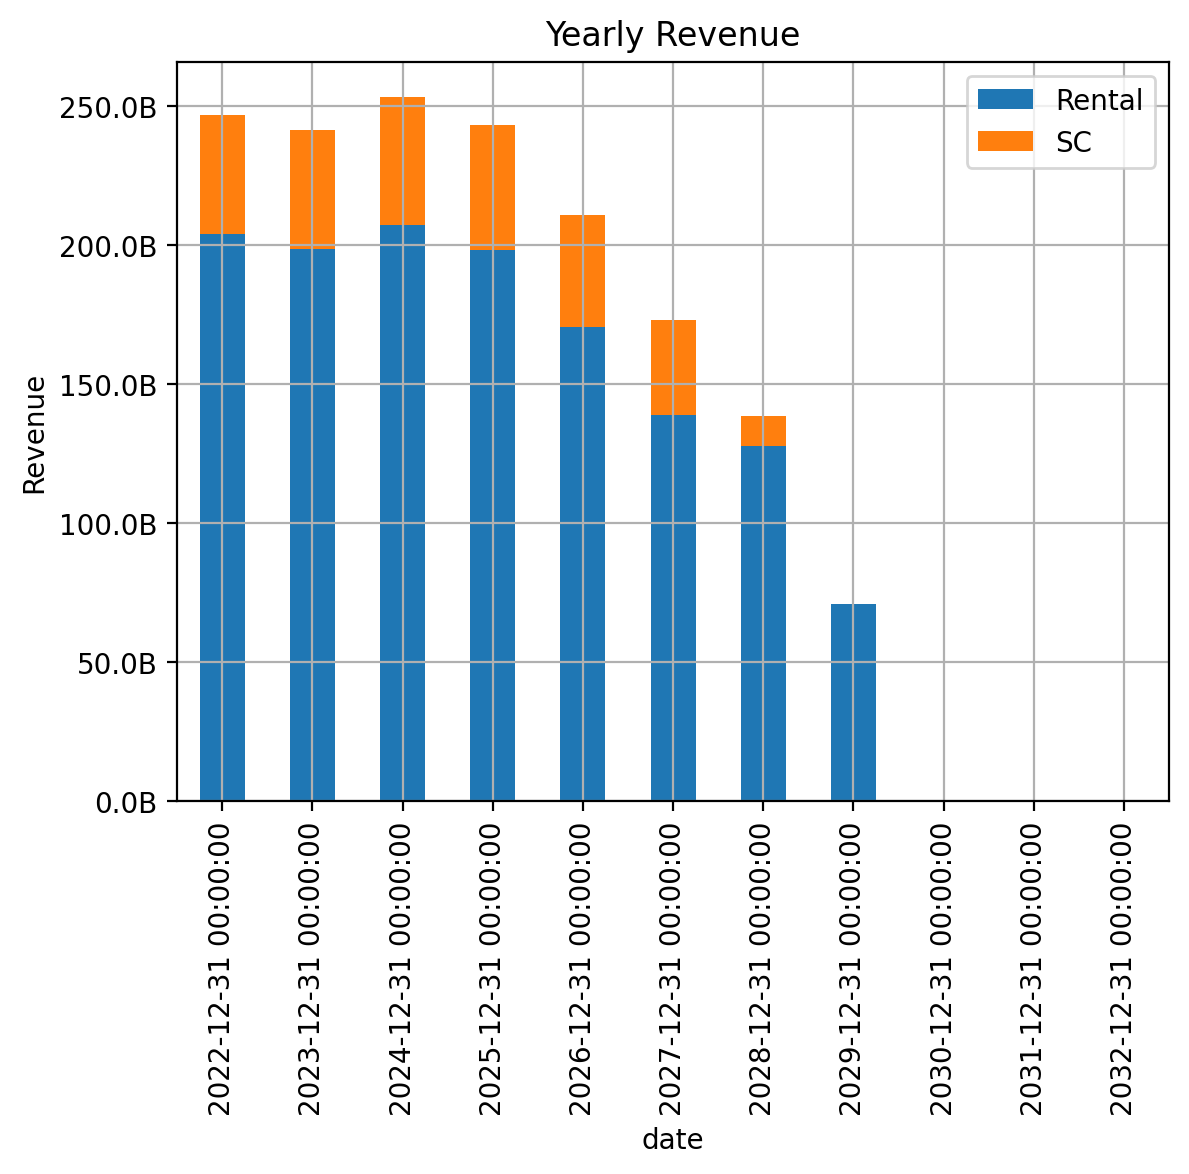

In [19]:
plt.figure()

ax = sum_df[['Rental','SC']].resample('Y').sum().plot.bar(fontsize=10, stacked=True)
ax.set_ylabel('Revenue')
ax.set_title('Yearly Revenue')
ax.grid()
#ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
#ax.yaxis.set_major_formatter(ticker.EngFormatter())

f = lambda x, pos: f'{x/10**9:,.1f}B'
ax.yaxis.set_major_formatter(FuncFormatter(f))

def line_format(label):
    """
    Convert time label to the format of pandas line plot
    """
    year = label.year
    #month = label.month_name()[:3]
    #if month == 'Jan':
    #    month += f'\n{label.year}'
    return year

#date_form = DateFormatter("%m-%Y")
#ax.set_xticklabels(map(line_format, sum_df.index))

#date_form = 
plt.show()

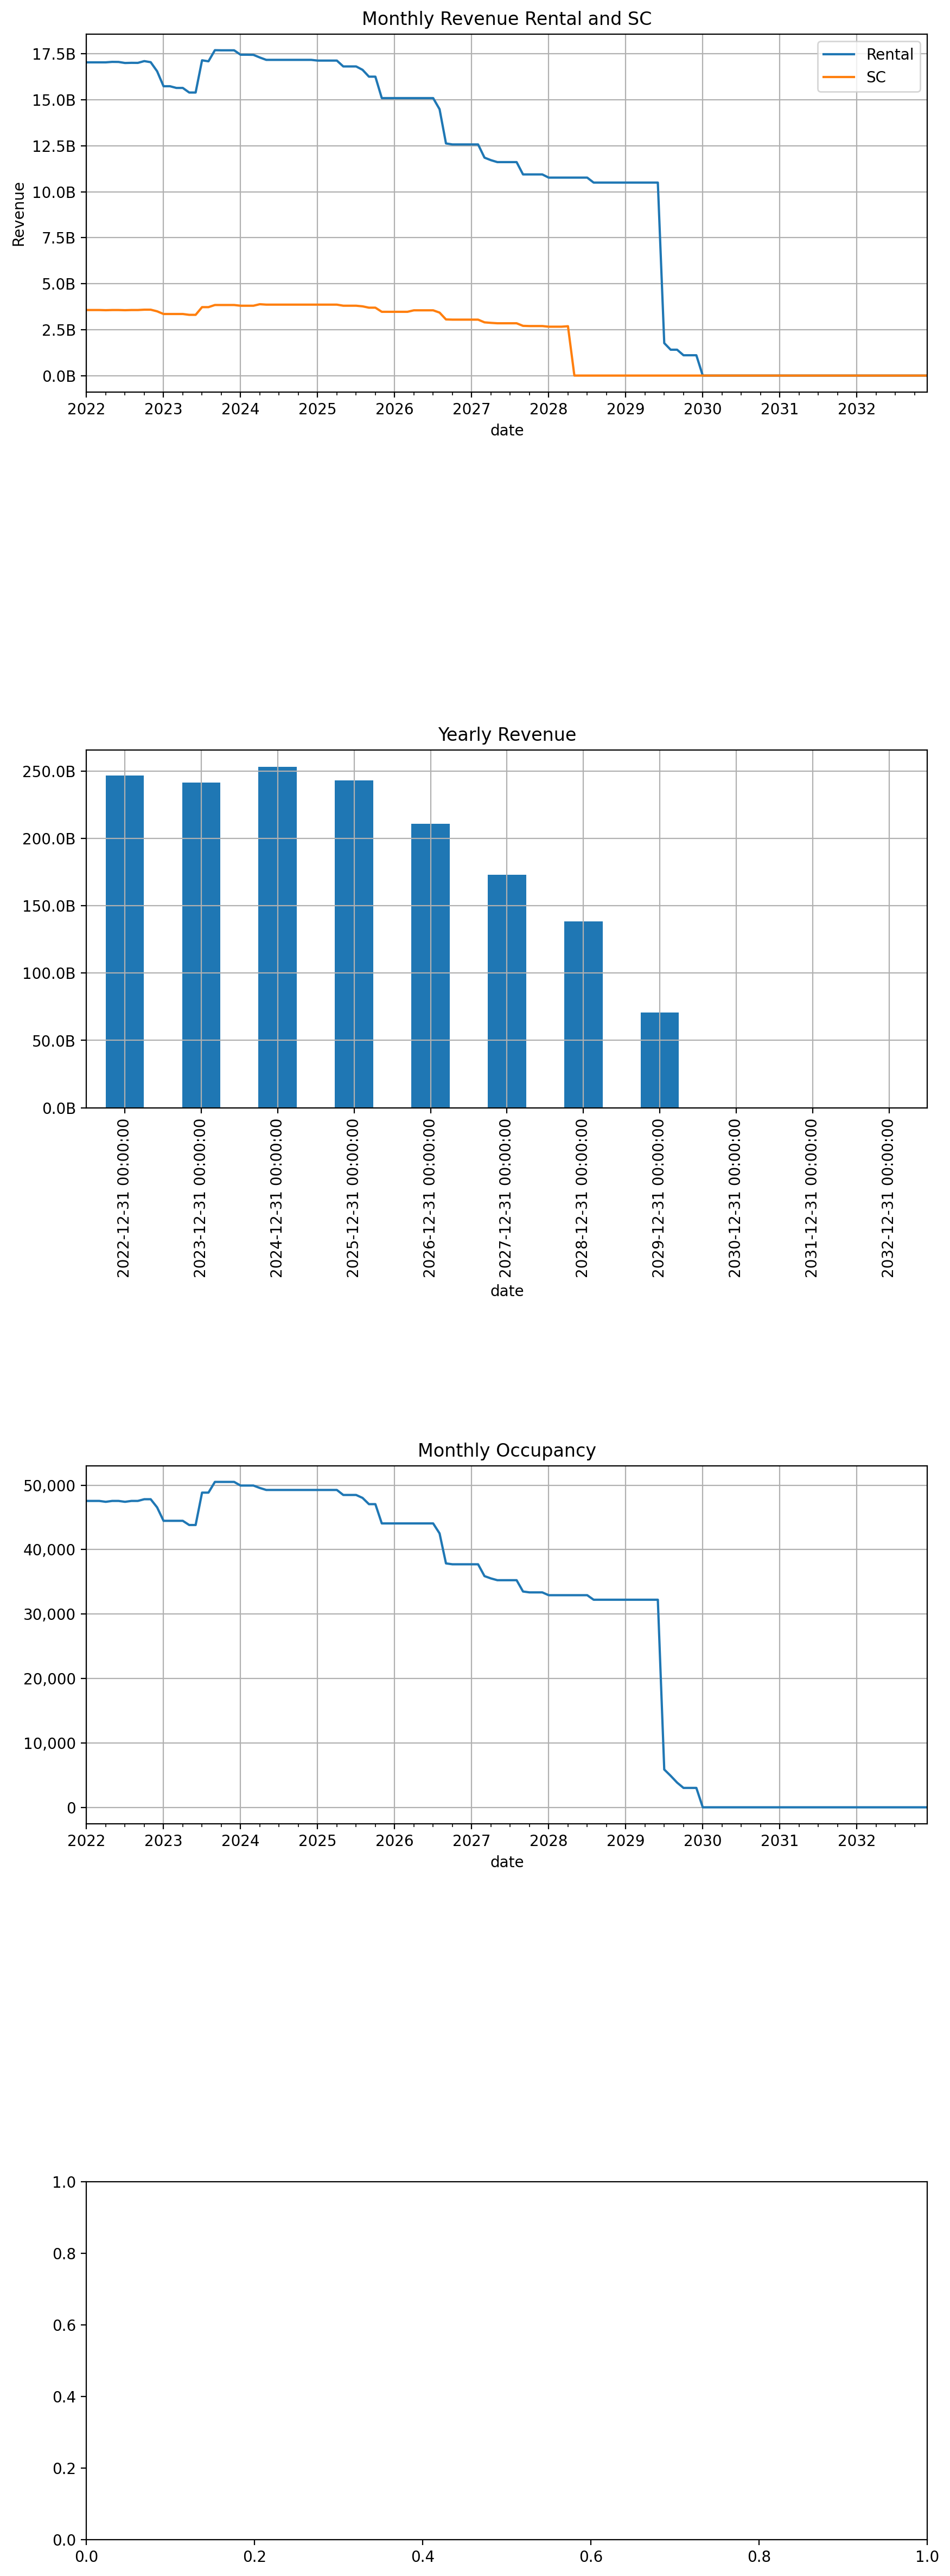

In [20]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,30))
plt.subplots_adjust(wspace=0.5,hspace=1)
sum_df[['Rental','SC']].plot(ax=axes[0], fontsize=10)
sum_df['Total'].resample('Y').sum().plot.bar(ax=axes[1], fontsize=10)
report_occupancy_df['sum'].plot(ax=axes[2], fontsize=10)
axes[0].set_title('Monthly Revenue Rental and SC')
axes[0].set_ylabel('Revenue')
axes[1].set_title('Yearly Revenue')
axes[2].set_title('Monthly Occupancy')
f = lambda x, pos: f'{x/10**9:,.1f}B'
axes[0].yaxis.set_major_formatter(FuncFormatter(f))
axes[1].yaxis.set_major_formatter(FuncFormatter(f))
axes[2].yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
axes[0].grid()
axes[1].grid()
axes[2].grid()
plt.show()


In [21]:
#total_df = pd.DataFrame(report_rental_charge_df.resample('Q').sum()['sum'])

#total2_df = pd.DataFrame()
#total2_df['Rental'] = report_rental_charge_df.resample('Q').sum()['sum']

#total2_df['SC'] = report_sc_charge_df.resample('Q').sum()['sum']

#total2_df['Total'] = total2_df.sum(axis=1)
#xw.view(total2_df)

In [22]:
#xw.view(report_rental_charge_df)